import libraries and read data

In [13]:
#!pip uninstall eodal -y
#!pip install git+https://github.com/lukasValentin/eodal.git@landsat-dev

In [14]:
#import what is needed
from datetime import datetime
from pathlib import Path
from shapely.geometry import box

from eodal.config import get_settings
from eodal.core.sensors import Landsat
from eodal.core.scene import SceneCollection
from eodal.mapper.feature import Feature

In [15]:
# read data from pickled file object into SceneCollectio
fpath = Path('S:\MSc_23_TimckeFinn\data\EOdal\sample_mapper_data.pkl')
scoll = SceneCollection.from_pickle(stream=fpath)
scoll

In [ ]:
# see which bands are available
for scene_id, scene in scoll:
    print(scene.band_aliases)
    print(scene.band_names)

['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'qa_pixel', 'qa_aerosol', 'qa_radsat', 'qa']
['blue', 'green', 'red', 'nir08', 'swir16', 'swir22', 'qa_pixel', 'qa_aerosol', 'qa_radsat', 'qa']


C:\Users\finnt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\ma\core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


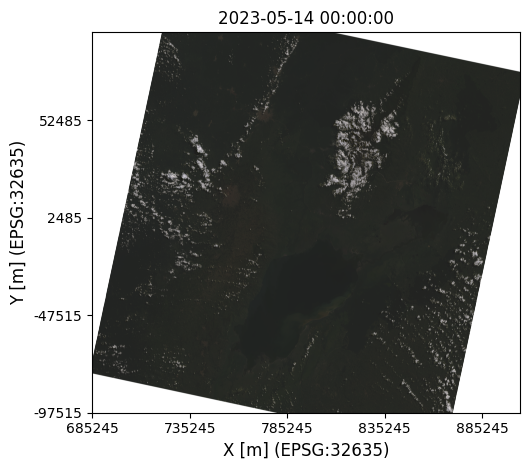

In [ ]:
%matplotlib inline  

# the scenes can be plotted
f_scenes = scoll.plot(['red', 'green', 'blue'])

Get values

In [ ]:
import numpy as np

# Specify the fill value
fill_value = -999

# Create a masked array
for scene_id, scene in scoll:
    # Get the values from the scene
    masked_array = scene.get_values()

    # Convert the masked array to a normal NumPy array with the fill value
    normal_array = masked_array.filled(fill_value)

    # Print the shape of the resulting normal array
    print(normal_array.shape)

    # Define the new shape of the array
    new_shape = (normal_array.shape[1] * normal_array.shape[2], normal_array.shape[0])
    print(new_shape)

    # Reshape the array with the new shape
    X = normal_array[:, :, :].reshape(new_shape)
    print(X.shape)



MemoryError: Unable to allocate 3.54 GiB for an array with shape (10, 6501, 7308) and data type float64

In [ ]:
from sklearn import cluster

k_means = cluster.KMeans(n_clusters=8)
k_means.fit(X)

# Get the cluster labels
X_cluster = k_means.labels_

# Reshape the cluster labels to match the shape of normal_array[0, :, :]
X_cluster = X_cluster.reshape(normal_array[0, :, :].shape)

X_cluster


C:\Users\finnt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


MemoryError: Unable to allocate 1.42 GiB for an array with shape (4, 47509308) and data type float64

(6501, 7308)


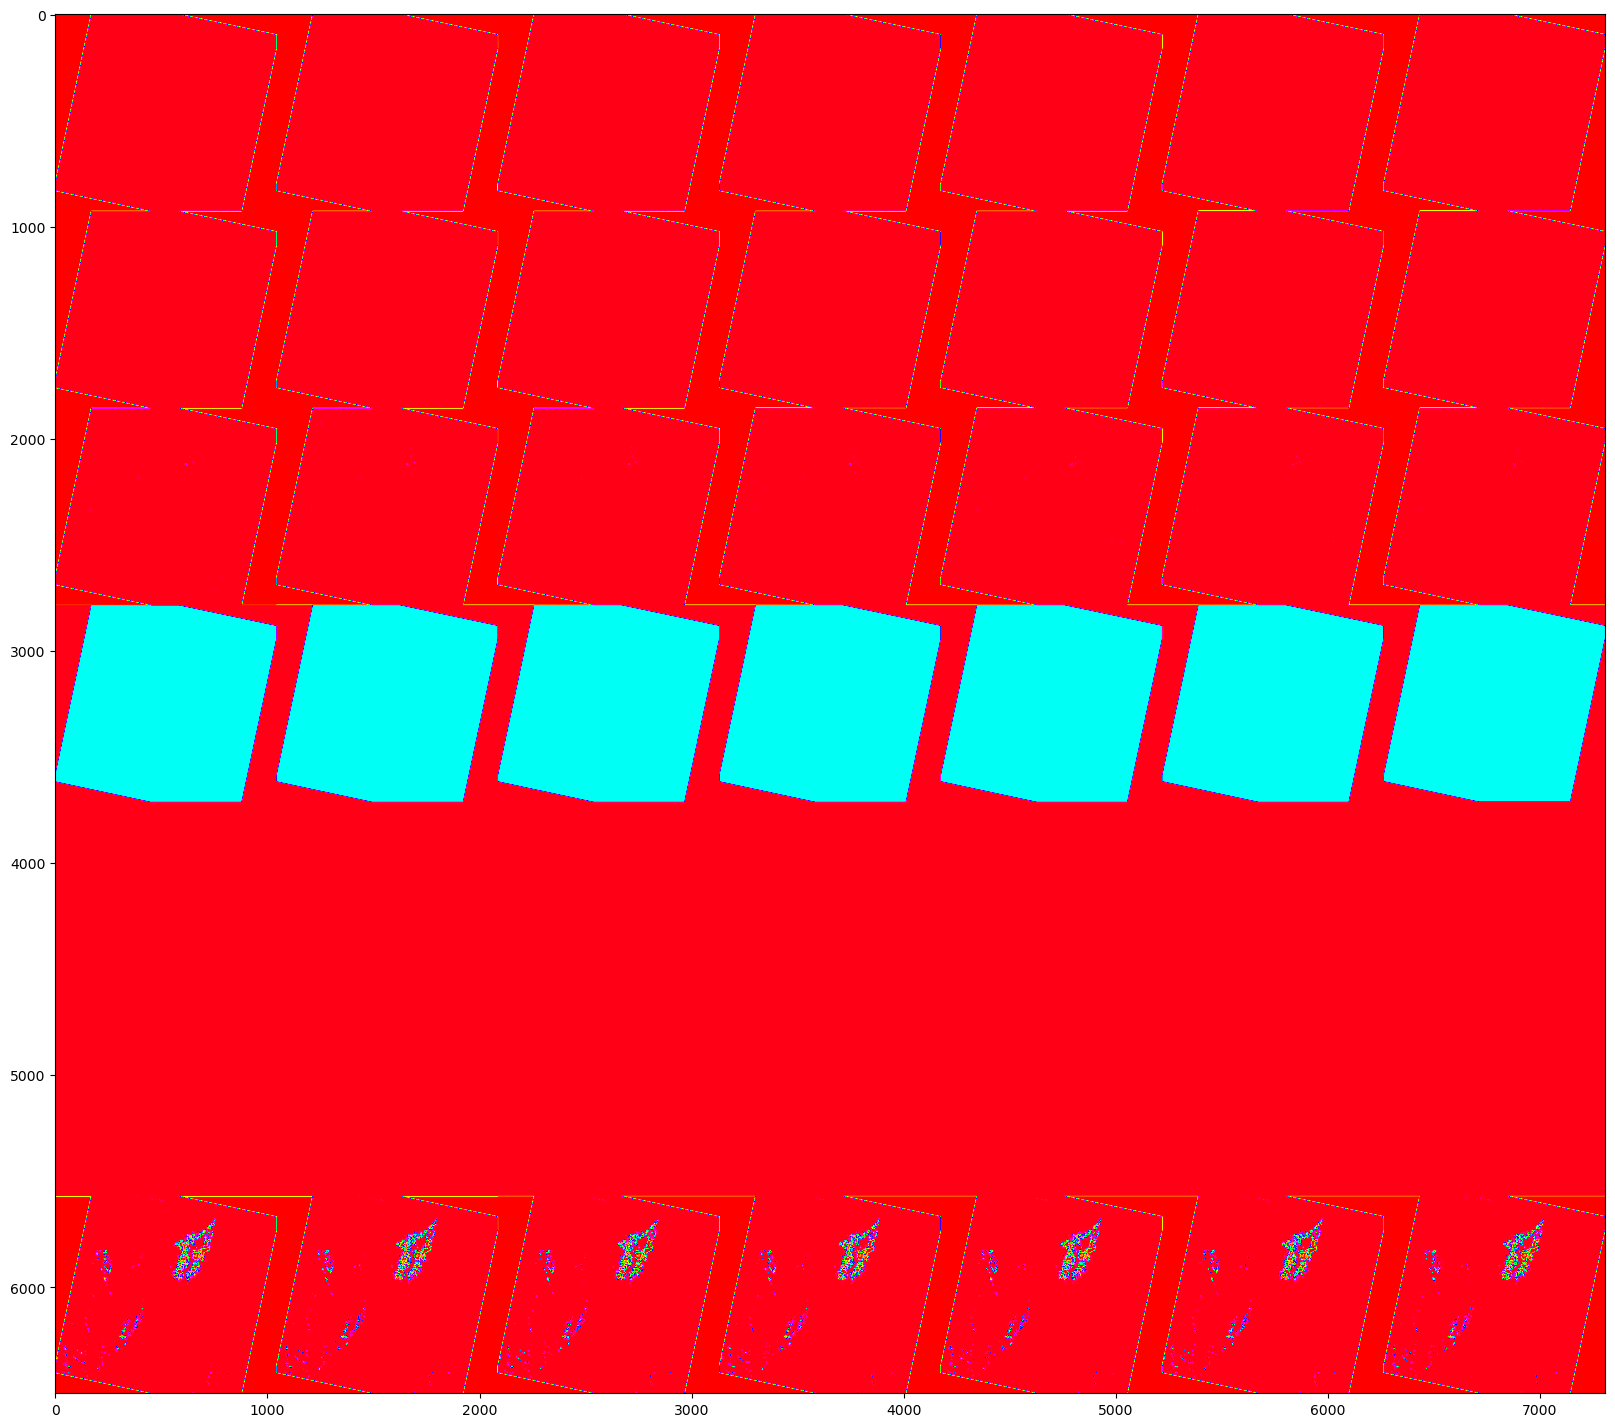

In [ ]:
%matplotlib inline  

import matplotlib.pyplot as plt

# Print the shape of X_cluster
print(X_cluster.shape)

# Set the figure size for the plot
plt.figure(figsize=(20, 20))

# Display the image using the X_cluster array and the "hsv" color map
plt.imshow(X_cluster, cmap="hsv")

# Show the plot
plt.show()
